## Week 2 Regression Homework

### Preparing the dataset

In [2]:
import pandas as pd

df=pd.read_csv('car_fuel_efficiency.csv')

In [4]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']

In [5]:
df[base]

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369
...,...,...,...,...,...
9699,140,164.0,2981.107371,2013,15.101802
9700,180,154.0,2439.525729,2004,17.962326
9701,220,138.0,2583.471318,2008,17.186587
9702,230,177.0,2905.527390,2011,15.331551


### EDA

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

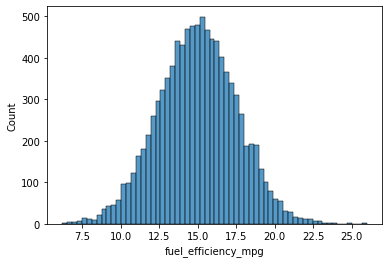

In [6]:
import seaborn as sns
# sns.histplot(y_pred, color="red", alpha=0.5, bins = 50)
# sns.histplot(y_train, color="blue", alpha=0.5, bins = 50) 

sns.histplot(df.fuel_efficiency_mpg)

From the above histgram, it does not have long tail feature.

### Question 1

There's one column with missing values. What is it?

* `engine_displacement`
* `horsepower`
* `vehicle_weight`
* `model_year`

In [ ]:
df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']].isnull().any()[lambda x: x].index[0]

'horsepower'

answer: horsepower

### Question 2

What's the median (50% percentile) for variable `'horsepower'`?

* 49
* 99
* 149
* 199

In [33]:
df['horsepower'].median()

149.0

answer: 149


#### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Use the same code as in the lectures

In [35]:
import numpy as np

np.random.seed(42)

# Shuffle the dataset
n = len(df)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx].reset_index(drop=True)

In [47]:
# Split into train/val/test (60%/20%/20%)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

print(f"Train: {len(df_train)}")
print(f"Val: {len(df_val)}")
print(f"Test: {len(df_test)}")

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Train: 5824
Val: 1940
Test: 1940


### Question 3

**We need to deal with missing values for the column from Q1.**

* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

**Options:**

- [ ] With 0
- [ ] With mean
- [ ] Both are equally good

In [55]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [56]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [57]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

In [58]:
def prepare_X_mean(df):
    df = df.copy()
    df_num = df[features]
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values
    return X

def prepare_X_zero(df):
    df = df.copy()
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [59]:
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values

Zero

In [64]:
X_train = prepare_X_zero(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_mean(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.5033985687929208

Mean

In [63]:
X_train = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_mean(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

0.46362369950314425

answer: With mean

### Question 4

**Now let's train a regularized linear regression.**

* For this question, fill the NAs with 0
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`
* Use RMSE to evaluate the model on the validation dataset
* Round the RMSE scores to 2 decimal digits
* Which `r` gives the best RMSE?
* If there are multiple options, select the smallest `r`

**Options:**

- [ ] 0
- [ ] 0.01
- [ ] 1
- [ ] 10
- [ ] 100

In [66]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [67]:
def prepare_X_mean(df):
    df = df.copy()
    df_num = df[features]
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values
    return X

def prepare_X_zero(df):
    df = df.copy()
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [70]:
min_value=np.inf
for r in [0, 0.01, 1, 10, 100]:
    
    X_train = prepare_X_zero(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X_mean(df_val)
    y_pred = w0 + X_val.dot(w)

    rmse_value = rmse(y_val, y_pred)
    if rmse_value<=min_value:
        target_r=r
        min_value=rmse_value
    print(f'r={r},rmse={rmse_value}')
print(f'final selection: {target_r} with rmse value {min_value}')

r=0,rmse=0.5033985687929208
r=0.01,rmse=0.5031528131622568
r=1,rmse=0.5085837247499415
r=10,rmse=0.5093612840402392
r=100,rmse=0.5094471229617149
final selection: 0.01 with rmse value 0.5031528131622568


answer: 0.01

### Question 5: Seed Stability Analysis

**We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.**

### Instructions:

1. Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`
2. For each seed, do the train/validation/test split with 60%/20%/20% distribution
3. Fill the missing values with 0 and train a model **without regularization**
4. For each seed, evaluate the model on the validation dataset and collect the RMSE scores
5. What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`
6. Round the result to 3 decimal digits using `round(std, 3)`

### Question: What's the value of std?

- [ ] 0.001
- [ ] 0.006
- [ ] 0.060
- [ ] 0.600

### Note:

Standard deviation shows how different the values are:
- If it's **low**, then all values are approximately the same
- If it's **high**, the values are different
- If standard deviation of scores is low, then our model is **stable**

In [74]:

import numpy as np


def seed_df_generation(seed_value=42):
    np.random.seed(seed_value)

    # Shuffle the dataset
    n = len(df)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx].reset_index(drop=True)

    # Split into train/val/test (60%/20%/20%)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    # print(f"Train: {len(df_train)}")
    # print(f"Val: {len(df_val)}")
    # print(f"Test: {len(df_test)}")

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    return df_train, df_val, df_test

In [75]:
total_rmse = []

for seed_value in [0,1,2,3,4,5,6,7,8,9]:
    df_train, df_val, df_test=seed_df_generation(seed_value)
    X_train = prepare_X_zero(df_train)
    
    y_train = df_train['fuel_efficiency_mpg'].values
    y_val = df_val['fuel_efficiency_mpg'].values
    
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X_mean(df_val)
    y_pred = w0 + X_val.dot(w)

    total_rmse.append(rmse(y_val, y_pred))
    
    
round(np.std(total_rmse), 3)

0.006

answer: 0.006

### Question 6: Final Model Evaluation

**Split the dataset like previously, use seed 9.**

#### Instructions:

1. Split the dataset like previously, use seed **9**
2. **Combine train and validation datasets**
3. Fill the missing values with **0** and train a model with `r=0.001`
4. What's the RMSE on the **test dataset**?

#### Question: What's the RMSE on the test dataset?

- [ ] 0.15
- [ ] 0.515
- [ ] 5.15
- [ ] 51.5

In [86]:
# Prepare New Data
df_train, df_val, df_test=seed_df_generation(9)

y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values


In [87]:
# Concate Trainning Data
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_train = prepare_X_zero(df_full_train)

y_full_train = np.concatenate([y_train, y_val])


In [89]:
w0, w = train_linear_regression_reg(X_train, y_full_train, r=0.001)

X_test = prepare_X_zero(df_test)
y_pred = w0 + X_test.dot(w)

rmse_value = rmse(y_test, y_pred)
rmse_value

0.5156261299185628

answer: 0.515